In [1]:
import os
import re
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split

C:\Users\IuG_Lap1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Exporting Data

In [2]:
dataset = load_dataset(path="./blbooks", name=None, trust_remote_code=True)

Generating train split: 100%|█████████████████████████████████████| 14011953/14011953 [37:23<00:00, 6246.44 examples/s]


In [3]:
def is_valid(example):
    try:
        # Keep only English pages that have non-null text and numeric values
        return (
            example["Language_1"] == "English"
            and example['multi_language'] == False
            and example["text"] is not None
            and isinstance(example["pg"], int)
            and isinstance(example["mean_wc_ocr"], float)
        )
    except:
        return False

filtered_dataset = dataset['train'].filter(is_valid)

Filter: 100%|████████████████████████████████████████████████████| 14011953/14011953 [09:26<00:00, 24714.00 examples/s]


In [4]:
filtered_dataset.save_to_disk("blbooks_hf_english_only")

Saving the dataset (44/44 shards): 100%|█████████████████████████| 10015767/10015767 [08:58<00:00, 18610.61 examples/s]


In [ ]:
from datasets import load_dataset
import pandas as pd

# Process in chunks
batch_size = 100_000
for i in range(0, len(train_dataset), batch_size):
    df_chunk = train_dataset[i : i + batch_size].to_pandas()
    df_chunk.to_parquet(f"blbooks_chunk_{i//batch_size}.parquet")

In [4]:
english_only = dataset["train"].filter(lambda x: x["Language_1"] == "English" and x['multi_language'] == False)
english_only.save_to_disk("blbooks_hf_english_only")

Saving the dataset (26/44 shards):  60%|███████████████▋          | 6044409/10015767 [08:04<05:18, 12485.69 examples/s]


OSError: [Errno 28] No space left on device

### Loading data from disk

In [3]:
from datasets import load_from_disk
import pandas as pd

dataset = load_from_disk("blbooks_hf_english_only")

batch_size = 100_000
for i in range(0, len(dataset), batch_size):
    batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
    df_chunk = batch.to_pandas()
    df_chunk.to_csv(f"english_blbooks_chunk_{i//batch_size}.csv", index=False)

Total pages: 10015767
Empty pages: 0
Number of unique titles: 34686
Top 10 publication places:
  London: 6809299
  New York: 398065
  Edinburgh: 290451
  Philadelphia: 167883
  Edinburgh ; London: 164298
  Chicago: 101312
  London ; New York: 96134
  Boston ; Massachusetts: 92030
  Dublin: 86932
  Boston: 84621
Average mean_wc_ocr: 0.73


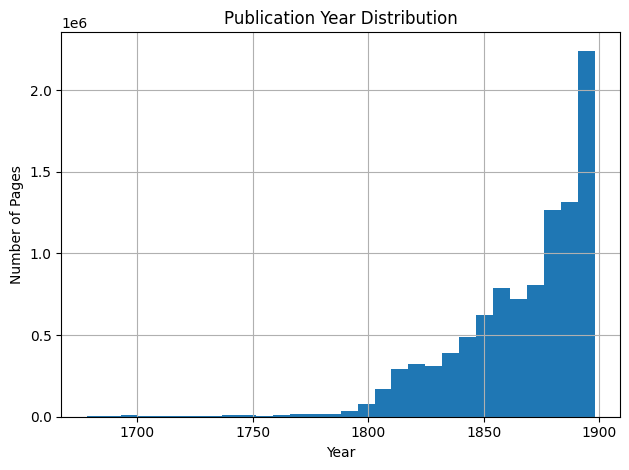

In [3]:
import pandas as pd
import glob
from collections import Counter

total_pages = 0
empty_pages = 0
place_counter = Counter()
total_words = 0
total_count = 0
unique_titles = set()
years = []

for file in glob.glob("blbooks/chunks/english_blbooks_chunk_*.csv"):
    cols = ["pg", "text", "place", "mean_wc_ocr", "title", "date"]
    chunk = pd.read_csv(file, usecols=cols)

    # Page counts
    total_pages += len(chunk)
    empty_pages += chunk["text"].isna().sum()

    # Places
    place_counter.update(chunk["place"].dropna())

    # OCR word count
    wc = chunk["mean_wc_ocr"].dropna()
    total_words += wc.sum()
    total_count += len(wc)

    # Collect unique titles
    titles = chunk["title"].dropna().unique()
    unique_titles.update(titles)


    # Extract year from date string (e.g., '1692-01-01' -> 1692)
    chunk["year"] = pd.to_datetime(chunk["date"], errors="coerce").dt.year
    years.extend(chunk["year"].dropna().astype(int).tolist())

# Save unique titles
titles_df = pd.DataFrame(sorted(unique_titles), columns=["title"])
titles_df.to_csv("unique_titles.csv", index=False)

# Output summary
print("Total pages:", total_pages)
print("Empty pages:", empty_pages)
print("Number of unique titles:", len(unique_titles))
print("Top 10 publication places:")
for place, count in place_counter.most_common(10):
    print(f"  {place}: {count}")
    
avg_wc = total_words / total_count if total_count else 0
print(f"Average mean_wc_ocr: {avg_wc:.2f}")

# Plot year distribution
pd.Series(years).hist(bins=30)
plt.title("Publication Year Distribution")
plt.xlabel("Year")
plt.ylabel("Number of Pages")
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
import glob

# Set to collect unique (title, author) pairs
unique_pairs = set()

# Loop over all data chunks
for file in glob.glob("blbooks/chunks/english_blbooks_chunk_*.csv"):
    print(f"Processing: {file}")
    chunk = pd.read_csv(file, usecols=["title", "name"])

    # Drop rows where title is missing
    chunk = chunk.dropna(subset=["title"])

    # Fill missing authors with empty string
    chunk["name"] = chunk["name"].fillna("")

    # Convert both fields to string
    chunk["title"] = chunk["title"].astype(str)
    chunk["name"] = chunk["name"].astype(str)

    # Add to set
    unique_pairs.update(zip(chunk["title"], chunk["name"]))

# Sort as strings to avoid type issues
df_unique = pd.DataFrame(list(unique_pairs), columns=["title", "author"])
df_unique = df_unique.sort_values("title")

# Save to CSV
df_unique.to_csv("unique_titles.csv", index=False)
print("Saved to unique_titles.csv")

Processing: blbooks/chunks\english_blbooks_chunk_0.csv
Processing: blbooks/chunks\english_blbooks_chunk_1.csv
Processing: blbooks/chunks\english_blbooks_chunk_10.csv
Processing: blbooks/chunks\english_blbooks_chunk_100.csv
Processing: blbooks/chunks\english_blbooks_chunk_11.csv
Processing: blbooks/chunks\english_blbooks_chunk_12.csv
Processing: blbooks/chunks\english_blbooks_chunk_13.csv
Processing: blbooks/chunks\english_blbooks_chunk_14.csv
Processing: blbooks/chunks\english_blbooks_chunk_15.csv
Processing: blbooks/chunks\english_blbooks_chunk_16.csv
Processing: blbooks/chunks\english_blbooks_chunk_17.csv
Processing: blbooks/chunks\english_blbooks_chunk_18.csv
Processing: blbooks/chunks\english_blbooks_chunk_19.csv
Processing: blbooks/chunks\english_blbooks_chunk_2.csv
Processing: blbooks/chunks\english_blbooks_chunk_20.csv
Processing: blbooks/chunks\english_blbooks_chunk_21.csv
Processing: blbooks/chunks\english_blbooks_chunk_22.csv
Processing: blbooks/chunks\english_blbooks_chunk_2

In [12]:
import pandas as pd

# Load title-author pairs
df_pairs = pd.read_csv("unique_titles.csv")

# Load labeled titles
df_labels = pd.read_csv("unique_titles_labeled.csv")

# Merge on title (case-sensitive match)
df_merged = df_pairs.merge(df_labels, on="title", how="left")

# Save merged file
df_merged.to_csv("unique_title_author_labeled.csv", index=False)
print("Saved to unique_title_author_labeled.csv")

Saved to unique_title_author_labeled.csv


In [13]:
_df = pd.read_csv("unique_title_author_labeled.csv")
for i, row in _df.iterrows():
    title = row["title"].lower()
    if "[a novel.]" in title or "[a tale.]" in title:
        _df.at[i, "is_novel"] = True

    if "a poem" in title or "[in verse.]" in title:
        _df.at[i, "is_novel"] = False
        
_df.to_csv("unique_title_author_labeled.csv", index=False)

In [11]:
from classify_titles_gpt import classify_titles_with_gpt 

In [14]:
classify_titles_with_gpt()

Loaded existing labeled titles.
All done.


In [23]:
_df = pd.read_csv("unique_title_author_labeled.csv")
for i, row in _df.iterrows():
    title = row["title"].lower()
    if "and other poems" in title:
        _df.at[i, "is_novel"] = False
        
_df.to_csv("unique_title_author_labeled.csv", index=False)

In [ ]:
import pandas as pd
import glob

# Load novel title labels
labeled = pd.read_csv("unique_titles_labeled.csv")
novel_titles = set(labeled[labeled["is_novel"] == True]["title"].dropna())

# Initialize counter
novel_pages = 0
total_pages = 0

# Process each chunk
for file in glob.glob("english_blbooks_chunk_*.csv"):
    chunk = pd.read_csv(file, usecols=["title"])
    total_pages += len(chunk)
    novel_pages += chunk["title"].isin(novel_titles).sum()

# Report results
print(f"Total pages: {total_pages}")
print(f"Pages from novels: {novel_pages}")
print(f"Percentage: {100 * novel_pages / total_pages:.2f}%")